# Advanced Data science Specialization IBM Capstone Project


## Project Title: Sleep Stages Scoring



This is a notebook for ETL, Train and Evaluation of data and results

In [1]:
# all necessary imports
import tensorflow as tf
import numpy as np
from matplotlib import pyplot as plt
import pandas as pd
import h5py
from scipy.stats import zscore

#from tensorflow import keras as k
from tensorflow.keras.layers import ConvLSTM2D
from tensorflow.keras.layers import Dense, Dropout,  Flatten, Reshape,  Input, Bidirectional, LSTM,  GRU
from tensorflow.keras.layers import MaxPool1D, Conv1D, Activation
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import regularizers
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.models import Model

In [2]:
tf.compat.v1.ConfigProto(
gpu_options=tf.compat.v1.GPUOptions(per_process_gpu_memory_fraction=0.8),
  allow_soft_placement=True)

gpu_options {
  per_process_gpu_memory_fraction: 0.8
}
allow_soft_placement: true

### ETL

#### Helper fuctions

In [2]:
def eeg_reader(data_path, label_path, label_ratio, orders):
    df = pd.read_csv(label_path, 
                 delimiter = '\t',header = None)
    labels = df.iloc[1:,1].values.astype(float)
    print(labels.shape)
    
    # upsampling labels
    ratio_ = label_ratio
    labels_ = np.zeros(len(labels) * ratio_)

    for i in range(ratio_):
        labels_[i::ratio_] = labels

    labels = labels_
    print('upsampled label size',labels.shape)
    
    # provide epoch_length
    epoch_length = int(1e4 / ratio_ )
    print('epoch_length', epoch_length, ', each epoch has 1 label')
    
    # correcting labels
    labels[labels==8] = 0
    print('labels corrected')
    
    # label info
    print('before correcting labels')
    print('1->', 'awake  |', '3->', 'REM   |' , '2->', 'sw  |',  '8->', 'artifact')
    print('after correcting labels')
    print('1->', 'awake  |', '3->', 'REM   |' , '2->', 'sw  |',  '0->', 'artifact')
    
    F = h5py.File(data_path)
    list(F.keys())
    CH1 = F[list(F.keys())[0]]['values']
    CH2 = F[list(F.keys())[1]]['values']
    CH3 = F[list(F.keys())[2]]['values']
    print('CH1', CH1.shape, 'CH2', CH2.shape, 'CH3', CH3.shape)
    signals = np.concatenate((CH1, CH2, CH3), axis = 0)
    print('concatinated shape', signals.shape)
    signals = np.array(signals.T)
    signals = signals[:,orders]
    print('final shape', signals.shape)

    print('adjusting signal length to label length')
    nr_epochs = int(np.floor(signals.shape[0] / epoch_length))
    signals = signals[0:int(nr_epochs * epoch_length),:]
    labels = labels[0:nr_epochs]
    print('nr of epochs ', nr_epochs, ' and adjusted signals length ', signals.shape[0])
    
    nr_classes = len(np.unique(labels))
    print('detected nr of classes', nr_classes)

    nr_features = signals.shape[1]
    print('detected nr of features', nr_features)

    print('creating aux_data')

    
    # make auxiliary data
    data_aux, dim0, t, f = make_aux_data(zscore(signals), epoch_length, labels)
    
    return data_aux, labels, epoch_length, nr_classes, t, f, signals
    
    
    
def make_aux_data(data, epoch_length, labels):
    # reshapeing data to fixed length size
    length = epoch_length # 
    #labels = y_train[0:3529]
    #data = signals
    print('full time length', data.shape[0], '   batch length', length, '   nr of features', data.shape[1])
    """
    Hint
    Input shape
    inputs: A 3D tensor with shape [batch, timesteps, feature]
    """

    # start transforming data to 3D tensor

    t, f = data.shape

    dim_0 = np.min([np.int(np.floor(data.shape[0] / length)), len(labels)])
    print('optimal zero dimension', dim_0)
    data_aux = np.zeros((dim_0, length, f))
    print('auxilary data initial size', data_aux.shape)
    for i in range(dim_0):
      data_aux[i] = data[i * length:i * length + length]

    print('auxilary data final size', data_aux.shape, '  labels final size', labels.shape)
    if data_aux.shape[0] !=len(labels):
      raise NameError('label length is different than batch nr in data' )
    
    return data_aux, dim_0, t, f

#### Loading data

Here I take data from local disk

In [108]:
# define path and load
data_path1 = 'I:/Marco/Sleep scoring/gcamp7_3_23_08_19/gcamp7m3_230819_filtered.mat'
label_path1 = 'I:/Marco/Sleep scoring/gcamp7_3_23_08_19/gcamp7m3_23_08_19_scoring_tot.txt'

data_path2 = 'I:/Marco/Sleep scoring/mpeegm17_19_05_10/mpeegm17_19_05_10.mat'
label_path2 = 'I:/Marco/Sleep scoring/mpeegm17_19_05_10/mpeegm17_19_05_10_tot.txt'

data_path3 = 'I:/Marco/Sleep scoring/gcamp7_m3_27_08_19/gcamp7_m3_m3_270819_filtered.mat'
label_path3 = 'I:/Marco/Sleep scoring/gcamp7_m3_27_08_19/gcamp7m3_27_08_19_scoring_tot.txt'

data_path4 = 'I:/Marco/Sleep scoring/gcamp7m2_19_07_17/gcamp7m2_19_07_17_filtered.mat'
label_path4 = 'I:/Marco/Sleep scoring/gcamp7m2_19_07_17/gcamp7m2_190717_tot.txt'

data_path5 = 'I:/Marco/Sleep scoring/gcamp7_m3_30_08_19/gcamp7m3_300819_filtered.mat'
label_path5 = 'I:/Marco/Sleep scoring/gcamp7_m3_30_08_19/gcamp7m3_30_08_19_scoring_tot.txt'

#data_path6 = 'I:/Marco/Sleep scoring/mouse3_18_11_13/mouse3_18_11_13_filtered_1.mat'
#label_path6 = 'I:/Marco/Sleep scoring/mouse3_18_11_13/mouse_3_18_11_13_1_tot.txt'

data_path7 = 'I:/Marco/Sleep scoring/gcamp7m3_19_08_21/gcamp7m3_19_08_21_filtered.mat'
label_path7 = 'I:/Marco/Sleep scoring/gcamp7m3_19_08_21/gcamp7m3_190821_scoring_tot.txt'

#data_path8 = 'I:/Marco/Sleep scoring/mouse3_18_11_13/mouse3_18_11_13_filtered_2.mat'
#label_path8 = 'I:/Marco/Sleep scoring/mouse3_18_11_13/mouse3_18_11_13_2_tot.txt'

#data_path9 = 'I:/Marco/Sleep scoring/mouse3_18_11_13/mouse3_18_11_13_filtered3.mat'
#label_path9 = 'I:/Marco/Sleep scoring/mouse3_18_11_13/mouse3_18_11_13_3_tot.txt'

data_aux1, labels1, epoch_length, nr_classes, t1, f, signals1 = eeg_reader(data_path1, label_path1, 1, [0, 1, 2])
print('%'*100)
data_aux2, labels2, epoch_length, nr_classes, t2, f, signals2 = eeg_reader(data_path2, label_path2, 1, [1, 2, 0])
print('%'*100)
data_aux3, labels3, epoch_length, nr_classes, t3, f, signals3 = eeg_reader(data_path3, label_path3, 1, [1, 2, 0])
print('%'*100)
data_aux4, labels4, epoch_length, nr_classes, t4, f, signals4 = eeg_reader(data_path4, label_path4, 1, [1, 2, 0])
print('%'*100)
data_aux5, labels5, epoch_length, nr_classes, t5, f, signals5 = eeg_reader(data_path5, label_path5, 1, [0, 1, 2])
print('%'*100)
#data_aux6, labels6, epoch_length, nr_classes, t6, f, signals6 = eeg_reader(data_path6, label_path6, 1)
print('%'*100)
data_aux7, labels7, epoch_length, nr_classes, t7, f, signals7 = eeg_reader(data_path7, label_path7, 1, [1, 2, 0])
print('%'*100)
#data_aux8, labels8, epoch_length, nr_classes, t8, f, signals8 = eeg_reader(data_path8, label_path8, 1)
print('%'*100)
#data_aux9, labels9, epoch_length, nr_classes, t9, f, signals9 = eeg_reader(data_path5, label_path9, 1)


(1625,)
upsampled label size (1625,)
epoch_length 10000 , each epoch has 1 label
labels corrected
before correcting labels
1-> awake  | 3-> REM   | 2-> sw  | 8-> artifact
after correcting labels
1-> awake  | 3-> REM   | 2-> sw  | 0-> artifact
CH1 (1, 16251999) CH2 (1, 16251999) CH3 (1, 16251999)


c:\users\admin\anaconda3\envs\tf2.0.0\lib\site-packages\ipykernel_launcher.py:31: H5pyDeprecationWarning: The default file mode will change to 'r' (read-only) in h5py 3.0. To suppress this warning, pass the mode you need to h5py.File(), or set the global default h5.get_config().default_file_mode, or set the environment variable H5PY_DEFAULT_READONLY=1. Available modes are: 'r', 'r+', 'w', 'w-'/'x', 'a'. See the docs for details.


concatinated shape (3, 16251999)
final shape (16251999, 3)
adjusting signal length to label length
nr of epochs  1625  and adjusted signals length  16250000
detected nr of classes 4
detected nr of features 3
creating aux_data
full time length 16250000    batch length 10000    nr of features 3
optimal zero dimension 1625
auxilary data initial size (1625, 10000, 3)
auxilary data final size (1625, 10000, 3)   labels final size (1625,)
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
(1226,)
upsampled label size (1226,)
epoch_length 10000 , each epoch has 1 label
labels corrected
before correcting labels
1-> awake  | 3-> REM   | 2-> sw  | 8-> artifact
after correcting labels
1-> awake  | 3-> REM   | 2-> sw  | 0-> artifact
CH1 (1, 12265000) CH2 (1, 12265000) CH3 (1, 12265000)
concatinated shape (3, 12265000)
final shape (12265000, 3)
adjusting signal length to label length
nr of epochs  1226  and adjusted signals length  12260000
detected 

### Data visualization

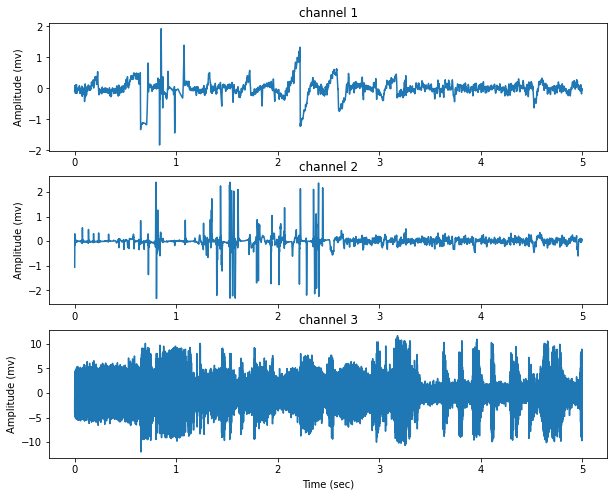

In [104]:
plt.figure(figsize=(10,8))
for i in range(3):
    plt.subplot(3,1,i+1)
    plt.plot(np.linspace(0,5, 50000), signals1[0:50000, i])
    plt.ylabel('Amplitude (mv)')
    plt.title('channel ' + str(i+1))
    if i==2:
        plt.xlabel('Time (sec)')

In [109]:
# concatenating several datasets
full_aux_data = np.concatenate((data_aux1, data_aux2, data_aux3, 
                                data_aux4, data_aux5,  data_aux7 
                                ), axis = 0)
full_labels = np.concatenate((labels1, labels2, labels3, labels4, 
                              labels5,  labels7))
print('full data set shape, ', full_aux_data.shape, '  full labels shape, ', full_labels.shape)
print('data in hour ', full_aux_data.shape[0]/360)

full data set shape,  (9278, 10000, 3)   full labels shape,  (9278,)
data in hour  25.772222222222222


#### Checking distribution of classes

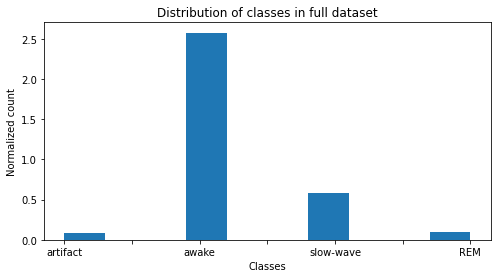

In [110]:
plt.figure(figsize=(8,4))

plt.hist(full_labels, density=True);
plt.ylabel('Normalized count')
plt.xlabel('Classes')
plt.title('Distribution of classes in full dataset');
plt.xticks([0, 0.5, 1.0, 1.5, 2.0, 2.5, 3.0],['artifact', '', 'awake', '', 'slow-wave', '', 'REM'])
plt.show()

As it clear the number of classes are not equal and we have unbalance dataset.   
To handle this problem I use sampling technique to create balance dataset.   
   
For our data I do random undersampling for classes awake and slow-wave   

The labels indicating classes are,   
1-> awake  | 3-> REM   | 2-> sw  | 0-> artifact

In [111]:
print('nr of awake labels %d\nnr of sw labels %d\nnr of REM labels %d\nnr of artifact labels %d' 
      %(np.where(full_labels==1)[0].shape[0], np.where(full_labels==2)[0].shape[0],np.where(full_labels==3)[0].shape[0],
       np.where(full_labels==0)[0].shape[0]))

nr of awake labels 7175
nr of sw labels 1606
nr of REM labels 274
nr of artifact labels 223


In [112]:
# small helper function for sampling
import random
def sampler_(data, nr):
    
    return random.sample(list(data[0]),nr)

In [113]:
temp_index1 = sampler_(np.where(full_labels==1),400)
temp_index2 = sampler_(np.where(full_labels==2),400)

new_data = np.concatenate((full_aux_data[full_labels==0], 
                          full_aux_data[full_labels==3],
                          full_aux_data[temp_index1],
                          full_aux_data[temp_index2]))

new_labels = np.concatenate((full_labels[full_labels==0], 
                          full_labels[full_labels==3],
                          full_labels[temp_index1],
                          full_labels[temp_index2]))

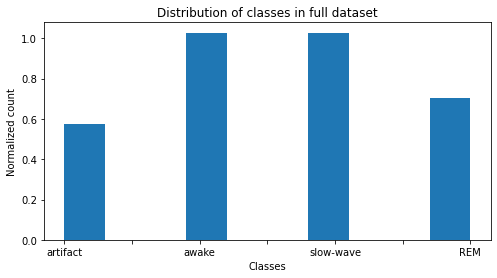

In [114]:
# checking new data's class distribution

plt.figure(figsize=(8,4))

plt.hist(new_labels, density=True);
plt.ylabel('Normalized count')
plt.xlabel('Classes')
plt.title('Distribution of classes in full dataset');
plt.xticks([0, 0.5, 1.0, 1.5, 2.0, 2.5, 3.0],['artifact', '', 'awake', '', 'slow-wave', '', 'REM'])
plt.show()

In [115]:
# checking size of remained data
print('data size', new_data.shape, '\nlabel size', new_labels.shape)

data size (1297, 10000, 3) 
label size (1297,)


#### Feature Engineering   

##### Dimension reduction   

First feature eng. started above during data load section where channels in all data scaled to have zeros mean and unit std.    In this section I try to reduce redundant features from data.   
To reduce redundent features, first, I concatenate channels then I apply PCA.

In [116]:
new_data_cat = np.zeros_like(new_data.reshape(-1,10000*3))
for i in range(new_data.shape[0]):
    new_data_cat[i] = np.concatenate((new_data[i,:,0],new_data[i,:,1],new_data[i,:,2]))
    
print('finished')
print('new_data_cat shape', new_data_cat.shape)

finished
new_data_cat shape (1297, 30000)


In [117]:
from sklearn.decomposition import PCA

# Here I apply PCA and keep first 100 components
pca = PCA(n_components=500, svd_solver='full')
# before feeding data to PCA I normalize them
newfeatures = pca.fit_transform(zscore(new_data_cat))

print('PCA is finished')
print('size of new features ', newfeatures.shape)

PCA is finished
size of new features  (1297, 500)


Now our features are ready and we can start classification model   


### Classification   

#### Machine learning based classification   
For this project I use powerfull technique called XGBoost

In [118]:
# test, train splitter
from sklearn.model_selection import train_test_split


x_train, x_test, y_train, y_test = train_test_split(newfeatures, new_labels, test_size=0.1, random_state=42)
print(x_train.shape, x_test.shape, y_train.shape, y_test.shape)

(1167, 500) (130, 500) (1167,) (130,)


Based on full features

In [119]:
from xgboost import XGBClassifier
#https://www.analyticsvidhya.com/blog/2016/03/complete-guide-parameter-tuning-xgboost-with-codes-python/
xgb = XGBClassifier(n_jobs=-1, num_parallel_tree=1, n_estimators=200, 
                    max_depth=20, objective = 'multi:softmax')

xgb.fit(x_train, y_train, eval_set=[(x_test, y_test)], 
        eval_metric =['merror', 'mlogloss'], verbose=False)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=20,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=200, n_jobs=-1, num_parallel_tree=1,
              objective='multi:softprob', random_state=0, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=None, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [120]:
from sklearn.metrics import accuracy_score

predict_ = xgb.predict(x_test)
accuracy = accuracy_score(y_test, predict_)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

Accuracy: 55.38%


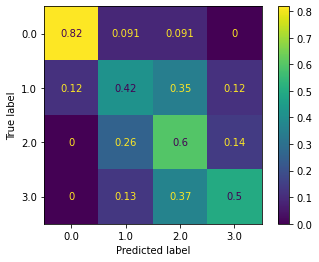

In [128]:
from sklearn.metrics import plot_confusion_matrix

plot_confusion_matrix(xgb, x_test, y_test, normalize= 'true')

#### Detecting best classifier and optimizing hyper-parameters

In [131]:
from sklearn.pipeline import Pipeline

from sklearn.linear_model import SGDClassifier, PassiveAggressiveClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.gaussian_process.kernels import RBF
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis

from sklearn.model_selection import g
from sklearn.preprocessing import StandardScaler

In [147]:
# preparing classifiers and parameters range for hyperparameters tunning

classifiers = [SGDClassifier(penalty='elasticnet', max_iter= 1000), MLPClassifier(learning_rate= 'adaptive', max_iter=1000), 
               KNeighborsClassifier(), SVC(max_iter=10000),  DecisionTreeClassifier(),
               RandomForestClassifier(), AdaBoostClassifier(), GaussianNB(), QuadraticDiscriminantAnalysis(),
               XGBClassifier(), PassiveAggressiveClassifier(max_iter=1000)]

Params = [dict(pca__n_components=[10, 50, 100, 250, 500],
               sgd__loss = ['hinge', 'log', 'modified_huber', 'squared_hinge'], sgd__l1_ratio = [.04, .08, .1, .13]), 
          dict(pca__n_components=[10, 50, 100, 250, 500], mlp__activation = ['tanh', 'relu']), 
          dict(pca__n_components=[10, 50, 100, 250, 500], kn__n_neighbors = [3, 5, 10, 15], 
               kn__leaf_size = [20, 30 ,40]), 
          dict(pca__n_components=[10, 50, 100, 250, 500], svc__C = [ 5, 20, 50, 70, 90]), 
          dict(pca__n_components=[10, 50, 100, 250, 500, 900], dc__criterion = ['gini', 'entropy']), 
          dict(pca__n_components=[10, 50, 100, 250, 500], rf__criterion = ['gini', 'entropy'], 
               rf__n_estimators = [40, 100, 200, 400, 800]), 
          dict(pca__n_components=[10, 50, 100, 250, 500], ad__n_estimators = [10, 20, 40, 100, 200, 400]), 
          dict(pca__n_components=[10, 50, 100, 250, 500] ), 
          dict(pca__n_components=[10, 50, 100, 250, 500], qd__reg_param = [0, .05, .1, .4]), 
          dict(pca__n_components=[10, 50, 100, 250, 500], xg__max_depth = [4, 6, 10, 15, 25], 
               xg__n_estimators = [50, 100, 200, 400, 800]), 
          dict(pca__n_components=[10, 50, 100, 250, 500], pa__C = [.1, .5, 1.])]

names = ['sgd', 'mlp', 'kn', 'svc', 'dc', 'rf', 'ad', 'gnb', 'qd', 'xg', 'pa']

### selecting best classifier with optimal parameters using GridSearch and CV

In [148]:
# to GridSearch and Pipeline are used within list comperhension

results = [GridSearchCV(Pipeline([('scaler', StandardScaler()),('pca', PCA()),(name, classifier)]), 
                        param_grid=param,  n_jobs=40, cv=5).fit(x_train, y_train) 
           for name, classifier, param in zip(names, classifiers, Params)]

In [149]:
[print(result.best_score_, '\n', result.best_params_, '\n', result.best_estimator_, '\n\n\n') for result in results]

0.3667143538388173 
 {'pca__n_components': 10, 'sgd__l1_ratio': 0.1, 'sgd__loss': 'squared_hinge'} 
 Pipeline(steps=[('scaler', StandardScaler()), ('pca', PCA(n_components=10)),
                ('sgd',
                 SGDClassifier(l1_ratio=0.1, loss='squared_hinge',
                               penalty='elasticnet'))]) 



0.48417886357800527 
 {'mlp__activation': 'relu', 'pca__n_components': 50} 
 Pipeline(steps=[('scaler', StandardScaler()), ('pca', PCA(n_components=50)),
                ('mlp',
                 MLPClassifier(learning_rate='adaptive', max_iter=1000))]) 



0.45413594512306954 
 {'kn__leaf_size': 40, 'kn__n_neighbors': 5, 'pca__n_components': 10} 
 Pipeline(steps=[('scaler', StandardScaler()), ('pca', PCA(n_components=10)),
                ('kn', KNeighborsClassifier(leaf_size=40))]) 



0.5167198562048348 
 {'pca__n_components': 50, 'svc__C': 70} 
 Pipeline(steps=[('scaler', StandardScaler()), ('pca', PCA(n_components=50)),
                ('svc', SVC(C=70, max_i

[None, None, None, None, None, None, None, None, None, None, None]

It seems that RandomForest classifier doing better than others   
Below I adjust parameters more to see how much I can improve the accuracy   

Running classifier on full features and after PCA dimension reduction

In [134]:
# base function
rndf = RandomForestClassifier(criterion='entropy', n_jobs=-1, n_estimators = 2000)
rndf.fit(x_train, y_train )

RandomForestClassifier(criterion='entropy', n_estimators=2000, n_jobs=-1)

In [135]:
# After PCA
rndf.score(x_test, y_test)

0.6

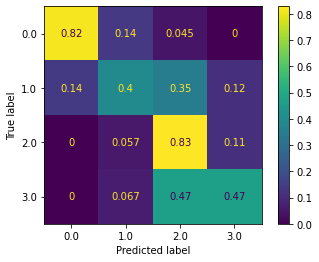

In [136]:
plot_confusion_matrix(rndf, x_test, y_test, normalize='true')

In [160]:
# Full features
rndf.score(x_test, y_test)

0.7

Just by changing number of estimators I could slighlty improve accuracy  
additionaly, it seems using full features increases accuracy. However using full features computationally is a expensive task and takes longer time.

#### Different feature engineering using FFT

In [137]:
from scipy.signal import stft

calculating stft per concatenated channel in each epoch, then data becomes (nr_samples, time_bins, frequency_bins)

In [138]:
new_data_fft = []
for j in range(new_data.shape[0]):
    temp = [stft(new_data[j,:,i], 1000, nperseg=512) for i in range(3)]
    #import pdb;pdb.set_trace()
    new_data_fft.append(np.hstack((temp[0][2], temp[1][2], temp[2][2])))
    
new_data_fft = np.array(new_data_fft)
print(new_data_fft.shape)

new_data_fft_log = np.zeros(new_data_fft.shape)
for i in range(new_data_fft.shape[0]):
    new_data_fft_log[i] = np.log(np.abs(new_data_fft[i]))
print(new_data_fft_log.shape)
print(new_data_fft_log.min(), new_data_fft_log.max())

(1297, 257, 123)


c:\users\admin\anaconda3\envs\tf2.0.0\lib\site-packages\ipykernel_launcher.py:12: RuntimeWarning: divide by zero encountered in log
  if sys.path[0] == '':


(1297, 257, 123)
-inf 2.8725757144861643


In [139]:
# removing -infs
new_data_fft_log = np.where(new_data_fft_log == np.NINF, 0, new_data_fft_log)
print(new_data_fft_log.min(), new_data_fft_log.max())

-56.87768941184357 2.8725757144861643


Text(0.5, 1.0, 'Example of stft on single epoch')

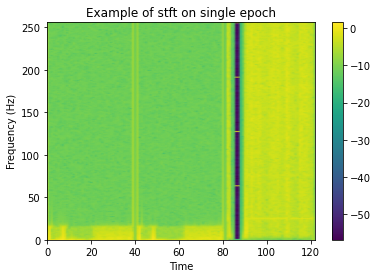

In [140]:
plt.pcolormesh(new_data_fft_log[100], shading='gouraud')
plt.colorbar()
plt.ylabel('Frequency (Hz)')
plt.xlabel('Time')
plt.title('Example of stft on single epoch')

In [141]:
x_train, x_test, y_train, y_test = train_test_split(new_data_fft_log.reshape(-1,257*123), new_labels, test_size=0.1, random_state=42)
print(x_train.shape, x_test.shape, y_train.shape, y_test.shape)

(1167, 31611) (130, 31611) (1167,) (130,)


running previous classifiers on new features

In [232]:
# running multiple classifiers with new features
results = [GridSearchCV(Pipeline([('scaler', StandardScaler()),('pca', PCA()),(name, classifier)]), 
                        param_grid=param,  n_jobs=40, cv=5).fit(x_train, y_train) 
           for name, classifier, param in zip(names, classifiers, Params)]

In [233]:
[print(result.best_score_, '\n', result.best_params_, '\n', result.best_estimator_, '\n\n\n') for result in results]

0.8303437144638861 
 {'pca__n_components': 500, 'sgd__l1_ratio': 0.1, 'sgd__loss': 'squared_hinge'} 
 Pipeline(steps=[('scaler', StandardScaler()), ('pca', PCA(n_components=500)),
                ('sgd',
                 SGDClassifier(l1_ratio=0.1, loss='squared_hinge',
                               penalty='elasticnet'))]) 



0.8106342393896042 
 {'mlp__activation': 'relu', 'pca__n_components': 50} 
 Pipeline(steps=[('scaler', StandardScaler()), ('pca', PCA(n_components=50)),
                ('mlp',
                 MLPClassifier(learning_rate='adaptive', max_iter=1000))]) 



0.7386889695902572 
 {'kn__leaf_size': 20, 'kn__n_neighbors': 3, 'pca__n_components': 10} 
 Pipeline(steps=[('scaler', StandardScaler()), ('pca', PCA(n_components=10)),
                ('kn', KNeighborsClassifier(leaf_size=20, n_neighbors=3))]) 



0.8389127324749642 
 {'pca__n_components': 50, 'svc__C': 50} 
 Pipeline(steps=[('scaler', StandardScaler()), ('pca', PCA(n_components=50)),
                ('svc', 

[None, None, None, None, None, None, None, None, None, None, None]

In [154]:
xgb = XGBClassifier(n_jobs=-1, num_parallel_tree=1, n_estimators=100, 
                    max_depth=55, objective = 'multi:softmax')

xgb.fit(x_train, y_train, eval_set=[(x_test, y_test)], 
       eval_metric =['merror', 'mlogloss'], verbose=False)



XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=55,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=-1, num_parallel_tree=1,
              objective='multi:softprob', random_state=0, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=None, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [155]:
predict_ = xgb.predict(x_test)
accuracy = accuracy_score(y_test, predict_)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

Accuracy: 82.31%


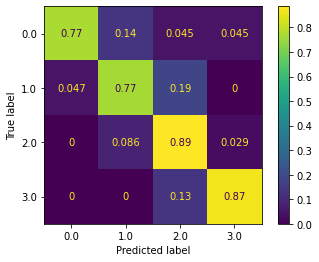

In [156]:
plot_confusion_matrix(xgb, x_test, y_test, normalize='true')

### Conclution

We got much better classification accuracy using stft based features Eng. Comparing best to best classifiers between two approches we were able to improve accuracy by __17%__.


### Classification using DeepLearning (Transfer Learning)

calculating stft per channel in each epoch, then data becomes (nr_samples, time_bins, frequency_bins, channels)

In [12]:
# I prepare data slightly differently here

new_data_fft_ = np.zeros((new_data.shape[0], 257, 41, 3))
for j in range(new_data.shape[0]):
    for k in range(3):
        _,_,Zxx = stft(new_data[j,:,k], 1000, nperseg=512)
        #import pdb;pdb.set_trace()
        new_data_fft_[j,:,:,k] = Zxx
    

print(new_data_fft_.shape)

new_data_fft_log_ = np.zeros(new_data_fft_.shape)
for i in range(new_data_fft_.shape[0]):
    new_data_fft_log_[i] = np.log(np.abs(new_data_fft_[i]))
print(new_data_fft_log_.shape)
print(new_data_fft_log_.min(), new_data_fft_log_.max())

print('new labels', new_labels.shape)

c:\users\admin\anaconda3\envs\tf2.0.0\lib\site-packages\ipykernel_launcher.py:8: ComplexWarning: Casting complex values to real discards the imaginary part
  


(1297, 257, 41, 3)


c:\users\admin\anaconda3\envs\tf2.0.0\lib\site-packages\ipykernel_launcher.py:15: RuntimeWarning: divide by zero encountered in log
  from ipykernel import kernelapp as app


(1297, 257, 41, 3)
-inf 2.8725757144861643
new labels (1297,)


In [13]:
# removing -infs
new_data_fft_log_ = np.where(new_data_fft_log_ == np.NINF, 0, new_data_fft_log_)
print(new_data_fft_log_.min(), new_data_fft_log_.max())

-60.68383777979256 2.8725757144861643


In [14]:
# prepare data and loading packages

from tensorflow.keras.preprocessing.image import array_to_img
from tensorflow.keras.preprocessing.image import img_to_array

test = list(map(img_to_array, map(array_to_img, new_data_fft_log_)))

data_ = np.stack(test,axis = 0)/255.

In [72]:
tf.keras.backend.clear_session()

Below, I load based model (Xception model) then in the first step I freeze parameters of based model and I define 2 dense layers with dropout as top layers. Then I train model to given data with freezed parameters of based model. When 2 top dense layers trained then we unfreeze the base model parameters and with low learning rate we fine-tune the all parameters.

In [73]:

base_model = tf.keras.applications.Xception(
    weights="imagenet",  # Load weights pre-trained on ImageNet.
    input_shape=(150, 120, 3),
    include_top=False,
)  

# Freeze the base_model
base_model.trainable = False

# Create new model on top
inputs = tf.keras.Input(shape=(257, 41, 3))

x = tf.image.resize(inputs, size= (150, 120), antialias=True) 

# The base model contains batchnorm layers. We want to keep them in inference mode
# when we unfreeze the base model for fine-tuning, so we make sure that the
# base_model is running in inference mode here.
x = base_model(x, training=False)
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.Dropout(0.5)(x)  # Regularize with dropout
x = tf.keras.layers.Dense(200, activation='relu')(x)
x = tf.keras.layers.Dropout(0.2)(x)  # Regularize with dropout
outputs = tf.keras.layers.Dense(4, activation='softmax')(x)
model = tf.keras.Model(inputs, outputs)

model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 257, 41, 3)] 0                                            
__________________________________________________________________________________________________
tf_op_layer_resize/Shape (Tenso [(4,)]               0           input_2[0][0]                    
__________________________________________________________________________________________________
tf_op_layer_resize/strided_slic [(2,)]               0           tf_op_layer_resize/Shape[0][0]   
__________________________________________________________________________________________________
tf_op_layer_resize/Cast (Tensor [(2,)]               0           tf_op_layer_resize/strided_slice[
______________________________________________________________________________________________

In [74]:
loss_fn = tf.keras.losses.categorical_crossentropy
optimizer = tf.keras.optimizers.Adam(1e-5)

In [75]:
# compile the model
model.compile(
    optimizer=optimizer,
    loss=loss_fn,
    metrics=['accuracy']
)


my_callbacks = [
    tf.keras.callbacks.EarlyStopping(patience=2),
]

In [76]:
from tensorflow.keras.utils import to_categorical
model.fit(x= data_, y = to_categorical(new_labels), epochs=100, validation_split=.1)

Train on 1167 samples, validate on 130 samples
Epoch 1/100
1167/1167 [==============================] - 8s 7ms/sample - loss: 1.3721 - accuracy: 0.3136 - val_loss: 1.3888 - val_accuracy: 0.0385
Epoch 2/100
1167/1167 [==============================] - 3s 2ms/sample - loss: 1.3386 - accuracy: 0.3376 - val_loss: 1.3915 - val_accuracy: 0.0231
Epoch 3/100
1167/1167 [==============================] - 3s 2ms/sample - loss: 1.3041 - accuracy: 0.4156 - val_loss: 1.3833 - val_accuracy: 0.0154
Epoch 4/100
1167/1167 [==============================] - 3s 2ms/sample - loss: 1.2653 - accuracy: 0.4627 - val_loss: 1.3797 - val_accuracy: 0.0154
Epoch 5/100
1167/1167 [==============================] - 3s 2ms/sample - loss: 1.2323 - accuracy: 0.4876 - val_loss: 1.3762 - val_accuracy: 0.0231
Epoch 6/100
1167/1167 [==============================] - 3s 2ms/sample - loss: 1.2121 - accuracy: 0.5133 - val_loss: 1.3705 - val_accuracy: 0.0462
Epoch 7/100
1167/1167 [==============================] - 3s 2ms/sample 

1167/1167 [==============================] - 3s 2ms/sample - loss: 0.8034 - accuracy: 0.6821 - val_loss: 1.0127 - val_accuracy: 0.5846
Epoch 57/100
1167/1167 [==============================] - 3s 2ms/sample - loss: 0.8002 - accuracy: 0.6769 - val_loss: 1.0077 - val_accuracy: 0.5846
Epoch 58/100
1167/1167 [==============================] - 3s 2ms/sample - loss: 0.7928 - accuracy: 0.6778 - val_loss: 0.9994 - val_accuracy: 0.5923
Epoch 59/100
1167/1167 [==============================] - 3s 2ms/sample - loss: 0.7945 - accuracy: 0.6829 - val_loss: 1.0039 - val_accuracy: 0.5846
Epoch 60/100
1167/1167 [==============================] - 3s 2ms/sample - loss: 0.8006 - accuracy: 0.6804 - val_loss: 0.9981 - val_accuracy: 0.5923
Epoch 61/100
1167/1167 [==============================] - 3s 2ms/sample - loss: 0.7684 - accuracy: 0.6924 - val_loss: 0.9956 - val_accuracy: 0.5923
Epoch 62/100
1167/1167 [==============================] - 3s 2ms/sample - loss: 0.7878 - accuracy: 0.6958 - val_loss: 0.9910 

#### Fine tunning full model

In [77]:
# Unfreeze the base model
base_model.trainable = True

# It's important to recompile your model after you make any changes
# to the `trainable` attribute of any inner layer, so that your changes
# are take into account
optimizer = tf.keras.optimizers.Adam(1e-7)
model.compile(
    optimizer=optimizer,
    loss=loss_fn,
    metrics=['accuracy']
)


# Train end-to-end. Be careful to stop before you overfit!
m_ = model.fit(x= data_, y = to_categorical(new_labels), epochs=300, validation_split=.1)

Train on 1167 samples, validate on 130 samples
Epoch 1/300
1167/1167 [==============================] - 17s 15ms/sample - loss: 0.7144 - accuracy: 0.7104 - val_loss: 0.9370 - val_accuracy: 0.6308
Epoch 2/300
1167/1167 [==============================] - 8s 7ms/sample - loss: 0.7049 - accuracy: 0.7078 - val_loss: 0.9307 - val_accuracy: 0.6154
Epoch 3/300
1167/1167 [==============================] - 8s 7ms/sample - loss: 0.6987 - accuracy: 0.7172 - val_loss: 0.9289 - val_accuracy: 0.6077
Epoch 4/300
1167/1167 [==============================] - 8s 7ms/sample - loss: 0.6924 - accuracy: 0.7138 - val_loss: 0.9252 - val_accuracy: 0.6231
Epoch 5/300
1167/1167 [==============================] - 8s 7ms/sample - loss: 0.6838 - accuracy: 0.7155 - val_loss: 0.9207 - val_accuracy: 0.6308
Epoch 6/300
1167/1167 [==============================] - 8s 7ms/sample - loss: 0.6781 - accuracy: 0.7147 - val_loss: 0.9266 - val_accuracy: 0.6308
Epoch 7/300
1167/1167 [==============================] - 8s 7ms/sampl

1167/1167 [==============================] - 8s 7ms/sample - loss: 0.6133 - accuracy: 0.7464 - val_loss: 0.9084 - val_accuracy: 0.6538
Epoch 57/300
1167/1167 [==============================] - 8s 7ms/sample - loss: 0.6051 - accuracy: 0.7429 - val_loss: 0.9054 - val_accuracy: 0.6538
Epoch 58/300
1167/1167 [==============================] - 8s 7ms/sample - loss: 0.6087 - accuracy: 0.7549 - val_loss: 0.9023 - val_accuracy: 0.6538
Epoch 59/300
1167/1167 [==============================] - 8s 7ms/sample - loss: 0.5862 - accuracy: 0.7635 - val_loss: 0.9015 - val_accuracy: 0.6692
Epoch 60/300
1167/1167 [==============================] - 8s 7ms/sample - loss: 0.6009 - accuracy: 0.7506 - val_loss: 0.9060 - val_accuracy: 0.6769
Epoch 61/300
1167/1167 [==============================] - 8s 7ms/sample - loss: 0.5895 - accuracy: 0.7601 - val_loss: 0.9055 - val_accuracy: 0.6846
Epoch 62/300
1167/1167 [==============================] - 8s 7ms/sample - loss: 0.6084 - accuracy: 0.7464 - val_loss: 0.9096 

1167/1167 [==============================] - 8s 7ms/sample - loss: 0.5488 - accuracy: 0.7738 - val_loss: 0.8764 - val_accuracy: 0.6846
Epoch 112/300
1167/1167 [==============================] - 8s 7ms/sample - loss: 0.5337 - accuracy: 0.7815 - val_loss: 0.8699 - val_accuracy: 0.6846
Epoch 113/300
1167/1167 [==============================] - 8s 7ms/sample - loss: 0.5320 - accuracy: 0.7892 - val_loss: 0.8759 - val_accuracy: 0.6846
Epoch 114/300
1167/1167 [==============================] - 8s 7ms/sample - loss: 0.5364 - accuracy: 0.7849 - val_loss: 0.8761 - val_accuracy: 0.6846
Epoch 115/300
1167/1167 [==============================] - 8s 7ms/sample - loss: 0.5193 - accuracy: 0.7883 - val_loss: 0.8809 - val_accuracy: 0.6846
Epoch 116/300
1167/1167 [==============================] - 8s 7ms/sample - loss: 0.5303 - accuracy: 0.7883 - val_loss: 0.8775 - val_accuracy: 0.6846
Epoch 117/300
1167/1167 [==============================] - 8s 7ms/sample - loss: 0.5332 - accuracy: 0.7849 - val_loss: 0

1167/1167 [==============================] - 8s 7ms/sample - loss: 0.4950 - accuracy: 0.8089 - val_loss: 0.8477 - val_accuracy: 0.6846
Epoch 167/300
1167/1167 [==============================] - 8s 7ms/sample - loss: 0.4915 - accuracy: 0.8055 - val_loss: 0.8458 - val_accuracy: 0.6846
Epoch 168/300
1167/1167 [==============================] - 8s 7ms/sample - loss: 0.4790 - accuracy: 0.8166 - val_loss: 0.8533 - val_accuracy: 0.6846
Epoch 169/300
1167/1167 [==============================] - 8s 7ms/sample - loss: 0.5010 - accuracy: 0.7892 - val_loss: 0.8436 - val_accuracy: 0.6846
Epoch 170/300
1167/1167 [==============================] - 8s 7ms/sample - loss: 0.4878 - accuracy: 0.8175 - val_loss: 0.8518 - val_accuracy: 0.6846
Epoch 171/300
1167/1167 [==============================] - 8s 7ms/sample - loss: 0.4780 - accuracy: 0.8063 - val_loss: 0.8498 - val_accuracy: 0.6846
Epoch 172/300
1167/1167 [==============================] - 8s 7ms/sample - loss: 0.4849 - accuracy: 0.8115 - val_loss: 0

1167/1167 [==============================] - 8s 7ms/sample - loss: 0.4495 - accuracy: 0.8320 - val_loss: 0.8358 - val_accuracy: 0.6923
Epoch 222/300
1167/1167 [==============================] - 8s 7ms/sample - loss: 0.4522 - accuracy: 0.8243 - val_loss: 0.8385 - val_accuracy: 0.6923
Epoch 223/300
1167/1167 [==============================] - 8s 7ms/sample - loss: 0.4350 - accuracy: 0.8260 - val_loss: 0.8515 - val_accuracy: 0.6923
Epoch 224/300
1167/1167 [==============================] - 8s 7ms/sample - loss: 0.4516 - accuracy: 0.8235 - val_loss: 0.8506 - val_accuracy: 0.6923
Epoch 225/300
1167/1167 [==============================] - 8s 7ms/sample - loss: 0.4540 - accuracy: 0.8132 - val_loss: 0.8440 - val_accuracy: 0.6923
Epoch 226/300
1167/1167 [==============================] - 8s 7ms/sample - loss: 0.4369 - accuracy: 0.8226 - val_loss: 0.8374 - val_accuracy: 0.6923
Epoch 227/300
1167/1167 [==============================] - 8s 7ms/sample - loss: 0.4467 - accuracy: 0.8158 - val_loss: 0

1167/1167 [==============================] - 8s 7ms/sample - loss: 0.4105 - accuracy: 0.8329 - val_loss: 0.8298 - val_accuracy: 0.6923
Epoch 277/300
1167/1167 [==============================] - 8s 7ms/sample - loss: 0.4141 - accuracy: 0.8398 - val_loss: 0.8260 - val_accuracy: 0.6923
Epoch 278/300
1167/1167 [==============================] - 8s 7ms/sample - loss: 0.4013 - accuracy: 0.8398 - val_loss: 0.8392 - val_accuracy: 0.6846
Epoch 279/300
1167/1167 [==============================] - 8s 7ms/sample - loss: 0.4003 - accuracy: 0.8380 - val_loss: 0.8338 - val_accuracy: 0.6923
Epoch 280/300
1167/1167 [==============================] - 8s 7ms/sample - loss: 0.4059 - accuracy: 0.8363 - val_loss: 0.8327 - val_accuracy: 0.6923
Epoch 281/300
1167/1167 [==============================] - 8s 7ms/sample - loss: 0.4127 - accuracy: 0.8320 - val_loss: 0.8327 - val_accuracy: 0.6923
Epoch 282/300
1167/1167 [==============================] - 8s 7ms/sample - loss: 0.4180 - accuracy: 0.8320 - val_loss: 0

In [87]:
deep_prediction = m_.model.predict(data_)
deep_prediction.shape

(1297, 4)

Text(0, 0.5, 'accuracy')

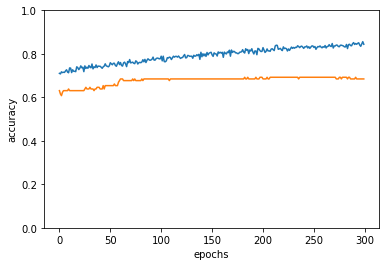

In [80]:
plt.plot(m_.history['accuracy'])
plt.plot(m_.history['val_accuracy'])
plt.ylim([0, 1])
plt.xlabel('epochs')
plt.ylabel('accuracy')

### Comparison


As we see from above graph model after 300 epoch stop learning and reached to ~69% accuracy on validation data.   
Comparing xgboost classifier and Xception model, we got much higher accuracy using machine learning classifier (xgboost) ~84%.